<head><b><center>MACHINE LEARNING</center>

<center>Redes Neuronales Artificiales</center>
<center>Redes Convolucionales</center>
    

<center>Profesor: Gabriel Jara </center></head><br>
El presente Jupyter Notebook busca:
<ul>
    <li>Explorar sobre el problema de clasificación de imágenes con ANN.</li>
    <li>Introducir la topología de convolución.</li>
    <li>Analizar y expandir la implementación de una capa de convolución.</li>
</ul>

Fuentes: Imágenes han sido robadas de internet y son enlaces a su correspondiente fuente. 

<b>En el capítulo anterior </b>

Desarrollamos implementación de <b><i>Multi-Layer Perceptron</i></b>, es decir redes neuronales densamente conectadas. 
<br> <img src=https://miro.medium.com/v2/resize:fit:563/1*4_BDTvgB6WoYVXyxO8lDGA.png
          width="350"/>
          
Esta topología será la base de nuestras redes neuronales, en general es adecuada para ofrecer solución a una basta gama de problemas. Pero es una solución general, que no tiene porque ser la mejora para cada problema en particular. 

Podemos expandir las capacidades de una red densa agregando otras topologías, que ya no tendrían por qué ser completamente conectadas. Sin embargo, las capas densas seguirán siendo una parte importante de nuestros modelos, así que mantendremos todo lo que ya tiene nuestra red neuronal, para luego agregar más cosas. 

<b>Reconocimiento de Imágenes con MNIST</b>

Seguiremos probado nuestra red con <b><i>Mnist</i></b>, colección de imágenes de dígitos (números) escritos a mano por distintas personas. 
<br> <img src=https://www.ttested.com/gallery/thumbnails/ditch-mnist.jpg
          width="400"/>

La siguiente celda carga muestras para entrenar y para testear resultados.     

In [1]:
from keras.datasets import mnist
import random
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# No necesitamos tantos datos.
(X_train, y_train), (X_test, y_test) = mnist.load_data()
#random.seed(123) # Vamos a controlar la aleatoriedad en adelante. 
X, y = zip(*random.sample(list(zip(X_train, y_train)), 2000))

# Sí necesitamos que la forma de X sea la de un vector, en lugar de una matriz. 
X, y = np.array(X, dtype='float64'), np.array(y, dtype='float64')
X = np.reshape(X, (X.shape[0], -1))

# Normalizamos Min-Max
X= MinMaxScaler().fit_transform(X)

# Dividimos la muestra en dos, una para entrenar y otra para testing, como tenemos 
# muestra de sobra nos damos el lujo de testear con la misma cantidad que entrenamos.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=123)

# Necesitamos que y_train sea un valor categórico, en lugar de un dígito entero.
y_train_value = y_train # Guardaremos y_train como valor para un observación más abajo.
from keras.utils import to_categorical
y_train = to_categorical(y_train)

<b>Implementación Base</b>

La siguiente es la misma implementación que dejamos en la clase previa. Se ha agregado dos de las tareas que se hicieron durante la clase, pero sigue pendiente la que se llevaron para la casa. Es decir, esta implementación no considera Mini Batch, y por lo tanto va a ser especialmente lento el proceso de entrenamiento.    

In [2]:
import numpy as np

# Clase base para Capa
class Layer:
    def __init__(self):
        self.input = None
        self.output = None
    # computes the output Y of a layer for a given input X
    def forward_propagation(self, input):
        raise NotImplementedError
    # computes dE/dX for a given dE/dY (and update parameters if any)
    def backward_propagation(self, output_error, learning_rate):
        raise NotImplementedError
        
# Clase para capas densas (fully connected)
class FCLayer(Layer):
    def __init__(self, input_size, output_size, lambda_reg=0):
        # np.random.seed(1234)
        self.weights = np.random.rand(input_size, output_size) - 0.5
        self.bias = np.random.rand(1, output_size) - 0.5
        self.lambda_reg = lambda_reg  # Se agrega parámetro coeficiente lambda de regularización L2

    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    def backward_propagation(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)

        # Adicionamos acá el término de regularización L2 que castiga error en los pesos
        weights_error += self.lambda_reg * self.weights

        # Actualizar los parámetros
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error
    
# Clase para Capa de Activación. Junto con la capa densa forman perceptrones. 
class ActivationLayer(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    # returns the activated input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    # Returns input_error=dE/dX for a given output_error=dE/dY.
    # learning_rate is not used because there is no "learnable" parameters.
    def backward_propagation(self, output_error, learning_rate):
        return self.activation_prime(self.input) * output_error
    
# Clase Red, conecta múltiples capas.
class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None

    # add layer to network
    def add(self, layer):
        self.layers.append(layer)

    # set loss to use
    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime

    # predict output for given input
    def predict(self, input_data):
        if input_data.ndim == 1: # YA NO SIEMPRE VAMOS A RECIBIR ARREGLOS UNIDIMENSIONALES
            input_data = np.array([[x] for x in input_data])
        samples = len(input_data)
        result = []

        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)
        return result

    # train the network
    def fit(self, x_train, y_train, epochs, learning_rate):
        if x_train[0].ndim == 1: # YA NO SIEMPRE VAMOS A RECIBIR ARREGLOS UNIDIMENSIONALES
            x_train = np.array([[x] for x in x_train])
        samples = len(x_train)
        # training loop
        for i in range(epochs):
            err = 0
            for j in range(samples):
                # forward propagation
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)

                # compute loss (for display purpose only)
                err += self.loss(y_train[j], output)

                # backward propagation
                error = self.loss_prime(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, learning_rate)

            # calculate average error on all samples
            err /= samples
            
            # Para usar en clasificación (con más de dos clases)
            # calculamos el error promedio entre nodos de salida.
            err = np.mean(err)
            
            # Imprimimos el error promedio de cada época, más que nada
            # para seguimiento del aprendizaje. 
            print('epoch %d/%d   error=%f' % (i+1, epochs, err))
            
# Funciones de Activación, y su correspondiente función derivada. 
def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1-np.tanh(x)**2

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    sig = sigmoid(x)  # Calculamos sigmoid(x) para cada elemento del vector
    return sig * (1 - sig)

def relu(x):
    return np.maximum(0, x)

def relu_prime(x):
    # Versión aproximada de ReLu', porque ReLu no es redivable en x=0
    # La derivada de ReLU es 1 si x > 0, y 0 si x <= 0
    return np.where(x > 0, 1, 0)

# función Leaky ReLU
def leaky_relu(x, alpha=0.01):
    # Si x es positivo, devuelve x; si no, devuelve alpha * x
    return np.where(x > 0, x, alpha * x)

# Implementamos la derivada de Leaky ReLU
def leaky_relu_prime(x, alpha=0.01):
    # La derivada es 1 si x > 0, y alpha si x <= 0
    return np.where(x > 0, 1, alpha)


# Funciones de pérdida y su derivada. 
# Error Cuadrático
def mse(y_true, y_hat):
    return (y_true-y_hat)**2

def mse_prime(y_true, y_hat):
    return 2*(y_hat-y_true)

# Entropía cruzada binaria
import numpy as np

# Implementamos la función de error BCE
def bce(y_true, y_hat):
    # Evitamos problemas de logaritmo aplicando un pequeño epsilon
    epsilon = 1e-15
    y_hat = np.clip(y_hat, epsilon, 1 - epsilon)
    
    return -(y_true * np.log(y_hat) + (1 - y_true) * np.log(1 - y_hat))

# Implementamos la derivada de BCE
def bce_prime(y_true, y_hat):
    # Evitamos problemas de división por 0
    epsilon = 1e-15
    y_hat = np.clip(y_hat, epsilon, 1 - epsilon)

    # Derivada de BCE con respecto a la predicción
    return -(y_true / y_hat) + (1 - y_true) / (1 - y_hat)


A continuación usamos nuestra red neuronal para aprender <i>Mnist</i> y evaluar el resultado. Vamos a probar con ReLu, BCE y regularización, en una red medianamente profunda.  

In [3]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Necesitamos identificar cuantos nodos tiene nuestra entrada, y eso depende del tamaño de X.
entrada_dim = len(X_train[0])

# Crear instancia de Network
model = Network()

# Agregamos capas al modelo
model.add(FCLayer(entrada_dim, 128))
model.add(ActivationLayer(relu, relu_prime))
model.add(FCLayer(128, 64))
model.add(ActivationLayer(sigmoid, sigmoid_prime))
model.add(FCLayer(64, 10)) 
model.add(ActivationLayer(sigmoid, sigmoid_prime))

# Asignamos función de pérdida
model.use(bce, bce_prime)

# Entrenamos el modelo con datos de entrenamiento
model.fit(X_train, y_train, epochs=10, learning_rate=0.1)

# Usamos el modelo para predecir sobre los datos de prueba (validación)
y_hat = model.predict(X_test)

# Transformamos la salida en un vector one-hot encoded, es decir 0s y un 1. 
for i in range(len(y_hat)):
    y_hat[i] = np.argmax(y_hat[i][0])

# Reportamos los resultados del modelo
matriz_conf = confusion_matrix(y_test, y_hat)

print('MATRIZ DE CONFUSIÓN para modelo ANN')
print(matriz_conf,'\n')
print('La exactitud de testeo del modelo ANN es: {:.3f}'.format(accuracy_score(y_test,y_hat)))

epoch 1/10   error=0.198011
epoch 2/10   error=0.097712
epoch 3/10   error=0.062564
epoch 4/10   error=0.033505
epoch 5/10   error=0.021414
epoch 6/10   error=0.009702
epoch 7/10   error=0.004849
epoch 8/10   error=0.002430
epoch 9/10   error=0.001461
epoch 10/10   error=0.001082
MATRIZ DE CONFUSIÓN para modelo ANN
[[ 99   0   1   1   0   1   0   0   0   0]
 [  0 113   0   0   0   0   0   0   2   0]
 [  1   0  93   2   3   2   3   1   1   0]
 [  0   1   6  88   0   4   1   4   6   0]
 [  0   1   0   0  90   0   0   0   0   5]
 [  2   0   0   3   0  76   2   0   5   0]
 [  6   0   2   0   1   1  60   0   0   0]
 [  0   0   2   1   2   2   0  94   0   5]
 [  1   3   1   2   0   8   3   0  76   0]
 [  0   2   2   3   6   4   0   4   3  89]] 

La exactitud de testeo del modelo ANN es: 0.878


In [4]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Necesitamos identificar cuantos nodos tiene nuestra entrada, y eso depende del tamaño de X.
entrada_dim = len(X_train[0])

# Crear instancia de Network
model = Network()

# Parámetro regularizados
lambda_reg = 0.001

# Agregamos capas al modelo
model.add(FCLayer(entrada_dim, 128, lambda_reg=lambda_reg))
model.add(ActivationLayer(relu, relu_prime))
model.add(FCLayer(128, 64, lambda_reg=lambda_reg))
model.add(ActivationLayer(sigmoid, sigmoid_prime))
model.add(FCLayer(64, 10, lambda_reg=lambda_reg)) 
model.add(ActivationLayer(sigmoid, sigmoid_prime))

# Asignamos función de pérdida
model.use(bce, bce_prime)

# Entrenamos el modelo con datos de entrenamiento
model.fit(X_train, y_train, epochs=10, learning_rate=0.1)

# Usamos el modelo para predecir sobre los datos de prueba (validación)
y_hat = model.predict(X_test)

# Transformamos la salida en un vector one-hot encoded, es decir 0s y un 1. 
for i in range(len(y_hat)):
    y_hat[i] = np.argmax(y_hat[i][0])

# Reportamos los resultados del modelo
matriz_conf = confusion_matrix(y_test, y_hat)

print('MATRIZ DE CONFUSIÓN para modelo ANN')
print(matriz_conf,'\n')
print('La exactitud de testeo del modelo ANN es: {:.3f}'.format(accuracy_score(y_test,y_hat)))

epoch 1/10   error=0.201044
epoch 2/10   error=0.092732
epoch 3/10   error=0.055642
epoch 4/10   error=0.042090
epoch 5/10   error=0.023824
epoch 6/10   error=0.018587
epoch 7/10   error=0.007482
epoch 8/10   error=0.004769
epoch 9/10   error=0.004220
epoch 10/10   error=0.004342
MATRIZ DE CONFUSIÓN para modelo ANN
[[ 99   0   2   1   0   0   0   0   0   0]
 [  0 111   0   0   0   0   0   0   3   1]
 [  1   0  95   1   4   1   2   1   1   0]
 [  0   0   8  83   0   6   1   3   8   1]
 [  0   1   0   0  92   0   0   0   1   2]
 [  3   1   0   0   0  77   1   0   5   1]
 [  7   0   0   0   1   2  58   1   1   0]
 [  0   1   1   0   4   1   0  97   0   2]
 [  1   1   2   2   0   3   1   0  84   0]
 [  0   1   1   2   5   2   0   6   3  93]] 

La exactitud de testeo del modelo ANN es: 0.889


Los resultados de estos dos experimentos, con y sin regularización, pueden variar. No asuma que es mejor (o peor) uno que el otro, en base a estos resultados en particular. Habría que hacer una búsqueda mucho más extensa de hiperparámetros, y validar más de una vez, para decir con mediana certeza qué es más conveniente. 

<b>REDES NEURONALES CONVOLUCIONALES (CNNs)</b>

Son una categoría especializada de red neuronal diseñada para procesar y transformar estructuras de datos grilla, como imágenes. Las CNNs están compuestas por una serie de capas que procesan pequeñas porciones de entrada, a menudo en forma de matrices (como píxeles en una imagen), para identificar características y patrones a diferentes niveles de complejidad.

Las CNNs poseen una habilidad única para detectar patrones espaciales y jerárquicos en imágenes. A diferencia de las técnicas tradicionales de procesamiento de imágenes, que requieren ingeniería manual de características, las CNNs aprenden automáticamente estas características directamente de los datos. Su arquitectura profunda, con múltiples capas, les permite extraer características a diferentes niveles, desde bordes básicos hasta estructuras más complejas como formas y patrones específicos. Esta capacidad de aprender y representar jerarquías de características las hace excepcionalmente poderosas para tareas de visión por computadora.

Las redes neuronales tradicionales, que hemos visto hasta aca, procesan la entrada a través de una serie de neuronas completamente conectadas. Esto significa que cada neurona en una capa está conectada a todas las neuronas en la capa anterior y a todas las neuronales en la capa siguiente. En contraste, las redes convolucionales introducen operaciones de convolución y pooling. Estas operaciones permiten a las CNNs concentrarse en pequeñas regiones espaciales de la entrada a la vez y compartir parámetros a través del espacio, lo que las hace más eficientes y adecuadas para datos estructurados grilla, como imágenes.

La topología típica de una CNN consta de varias capas, y cada capa tiene un propósito específico:

<b>Capa de Convolución (Convolutional Layer)</b>: En esta capa se aplican filtros a una pequeña ventana (por ejemplo, 3x3 o 5x5 píxeles) de la imagen. Estos filtros se desplazan alrededor de la imagen para producir un mapa de características (feature map). Es la capa responsable de detectar patrones locales como bordes, texturas y otros detalles finos. Los pesos de los filtros son aprendidos durante el entrenamiento. La salida de una capa de convolución se denomina mapa de características (feature map). 

<b>Función de Activación</b>: Después de una capa de convolución, generalmente, se aplica una función de activación. La función de activación ReLU (Rectified Linear Unit) es la más utilizada en CNNs. Añade no linealidad al modelo, permitiendo que la red capture patrones más complejos.

<b>Capa de Pooling (Pooling Layer)</b>: Suele incluirse una capa de pooling después de una capa de convolución, pero no es obligatorio. Reduce la dimensión espacial (ancho y alto) del mapa de características, conservando las características más importantes. El pooling más común es el Max Pooling, donde se toma el valor máximo de una ventana (por ejemplo, 2x2 píxeles). Ayuda a hacer que la red sea menos sensible a pequeñas variaciones y disminuye la cantidad de parámetros, reduciendo así el riesgo de sobreajuste y el costo computacional.

<b>Capa Totalmente Conectada (Fully Connected Layer)</b>: Después de varias capas de convolución y pooling, la información se aplana y se alimenta a una o más capas totalmente conectadas, similares a las de una red neuronal tradicional. En estas capas, se realizan las combinaciones finales de características para tomar decisiones o clasificaciones.

Probemos en primer lugar que pasa si a nuestra red neuronal le agregamos una capa de convolución con activación ReLU. Pare ello primero necesitamos programar una capa de convolucion...

<b>Convolución </b>

¿Qué es la convolución? Es una operación matricial que describe una forma de multiplicar dos matrices para producir una tercera. La podemos dividir en dos partes, la primera se denomina <i>Correlación</i> (o correlación cruzada), la segunda es propiamente la <i>Convolución</i>. 

<i>Correlación</i>

$$(I * K)(x, y) = \sum_{i=-N}^{N} \sum_{j=-M}^{M} I(x - i, y - j) K(i, j)$$

La operación consiste en recorrer la imagen $I$ extrayendo segmentos del mismo tamaño que el kernel $k$, aplicando la transformación lineal que se produce de sumar la multiplicación de cada pixel en el segmento por su correspondiente peso en el kernel, es decir el Producto Punto de ambas matrices.  
<br> <img src=https://upload.wikimedia.org/wikipedia/commons/1/19/2D_Convolution_Animation.gif
          width="300"/> </br>

<i>Convolución</i>

Consiste en invertir el orden de la matriz tanto horizontal como verticalmente. Es equivalente a obtener un reflejo de la matriz original. 

Durante fordware propagation sólo se hace la operación de Correlación, es decir la operación matricial basada en producto punto (suma de multiplicaciones de elementos). El kernel está operando como pesos $w$ de la red. 

Durante backward propagation se utiliza Convolución y Correlación, para asegurar que el orden en que se aplica los ajustes a los pesos se corresponda con la posición del kernel, ahora que vamos en dirección contraria (hacia atrás). 

<b>¿Qué pasa con lo bordes de la imagen?</b> Para que no se pierda la información del borde de la imagen podemos establecer que se rellene con valores del borde cuando sea necesario, de forma que cada pixel de la imagen $I$, incluso las esquinas, pueda ser incluido como centro de un kernel $K$. Este proceso se llama <i>padding</i>.  Los valores con los que se rellena el borde pueden ser una constante (cero, media...), o bien se repite los valores adyacentes al propio borde.  

Los pesos del kernel son parámetros a aprender durante el entrenamiento de la red, es decir se irán actualizando durante la etapa de backward propagation, y se usan para obtener la predicción en fordware propagation.    

<b>Capa de Convolución</b>

In [5]:
import numpy as np

# La capa de convolución hereda de la clase base, madre de todas las capas
class ConvLayer(Layer):
    def __init__(self, input_shape, kernel_shape, num_kernels, lambda_reg=0):
        self.input_shape = input_shape  # Tamaño de la entrada (alto, ancho, profundidad)
        self.input_depth = input_shape[2]  # Profundidad de la entrada (número de canales)
        self.kernel_shape = kernel_shape  # Tamaño del kernel (alto, ancho)
        self.num_kernels = num_kernels  # Número de kernels (cada uno genera una salida)
        self.lambda_reg = lambda_reg  # Factor de regularización L2
        # La salida tendrá el mismo tamaño de entrada
        # esto no tendría por qué ser así, pero nos ahorra problemas para manejar tamaños entre capas
        self.output_shape = (input_shape[0], input_shape[1], num_kernels) 
        # Inicializamos los pesos de forma aleatoria con rango entre -0.5 y 0.5
        self.weights = np.random.rand(kernel_shape[0], kernel_shape[1], self.input_depth, num_kernels) - 0.5
        self.bias = np.random.rand(num_kernels) - 0.5

    # Función para agregar padding a la entrada
    # es necesario para mantener el tamaño de la matriz
    def pad_input(self, input_matrix, pad):
        # Agregamos padding de ceros alrededor de la matriz de entrada
        return np.pad(input_matrix, ((pad, pad), (pad, pad)), mode='constant', constant_values=0)

    # Correlación 2D
    # la parte previa a la convolución, que además sirve de convolución en fordward prop
    def correlate(self, input_matrix, kernel):
        # Obtenemos las dimensiones de entrada y del kernel
        input_height, input_width = input_matrix.shape
        kernel_height, kernel_width = kernel.shape
        # Calculamos las dimensiones de la salida tras la correlación
        output_height = input_height - kernel_height + 1
        output_width = input_width - kernel_width + 1
        # Inicializamos la salida como una matriz de ceros
        output = np.zeros((output_height, output_width))

        # Recorremos la entrada y aplicamos la correlación
        for i in range(output_height):
            for j in range(output_width):
                # Las dos iteraciones controlan el movimiento de una ventana que recorre
                # a lo ancho y a lo alto la matriz original, extayendo submatrices
                sub_matrix = input_matrix[i:i+kernel_height, j:j+kernel_width]  # Seleccionamos la submatriz de la entrada
                output[i, j] = np.sum(sub_matrix * kernel)  # Producto punto entre la submatriz y el kernel

        return output

    # Convolución 2D (correlación con kernel volteado)
    # usaremos la convolución en la etapa de backward prop
    def convolve(self, input_matrix, kernel):
        # Volteamos el kernel en ambas direcciones (filas y columnas)
        flipped_kernel = np.flipud(np.fliplr(kernel))
        # Aplicamos la correlación con el kernel volteado
        return self.correlate(input_matrix, flipped_kernel)

    def forward_propagation(self, input_data):
        # Guardamos la entrada para usarla en backward_propagation
        self.input = input_data
        # Inicializamos la salida con ceros
        self.output = np.zeros(self.output_shape)

        # Calculamos el padding en función del tamaño del kernel
        pad_h = self.kernel_shape[0] // 2
        pad_w = self.kernel_shape[1] // 2

        # Recorremos cada filtro en la profundidad de la capa
        for k in range(self.num_kernels):
            for d in range(self.input_depth):
                # Agregamos padding a la entrada actual (canal d)
                padded_input = self.pad_input(self.input[:,:,d], pad_h)
                # Realizamos la correlación y obtenemos la salida parcial
                correlated_output = self.correlate(padded_input, self.weights[:,:,d,k])
                # Sumamos el resultado de la correlación al acumulador de la salida
                self.output[:,:,k] += correlated_output[:self.output_shape[0], :self.output_shape[1]]  
            # Añadimos el bias al filtro actual
            self.output[:,:,k] += self.bias[k]

        return self.output

    def backward_propagation(self, output_error, learning_rate):
        # Inicializamos los errores de entrada y de pesos como matrices de ceros
        in_error = np.zeros(self.input_shape)
        weights_error = np.zeros((self.kernel_shape[0], self.kernel_shape[1], self.input_depth, self.num_kernels))
        dBias = np.zeros(self.num_kernels)

        # Calculamos el padding basado en el tamaño del kernel
        pad_h = self.kernel_shape[0] // 2
        pad_w = self.kernel_shape[1] // 2

        # Con cada kernel recorreremos cada capa de la entrada. 
        for k in range(self.num_kernels):
            for d in range(self.input_depth):
                # Aplicamos padding al error de salida antes de convolucionarlo con los pesos
                padded_output_error = self.pad_input(output_error[:,:,k], pad_h)
                # Realizamos la convolución inversa y la sumamos al error de entrada
                convolved_error = self.convolve(padded_output_error, self.weights[:,:,d,k])
                in_error[:,:,d] += convolved_error[:self.input_shape[0], :self.input_shape[1]]  
                # Calculamos el error de los pesos usando correlación entre entrada y error
                weights_error[:,:,d,k] = self.correlate(self.input[:,:,d], output_error[:,:,k])
            # Sumamos el error del bias en la salida actual
            dBias[k] = np.sum(output_error[:,:,k])  

        # Aplicamos la regularización L2 sobre los errores de los pesos
        weights_error += self.lambda_reg * self.weights

        # Actualizamos los pesos y los sesgos usando el gradiente descendente
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * dBias

        # Retornamos el error de la entrada para la siguiente capa
        return in_error


La salida de la capa de convolución será tantas representaciones de la imagen original (del mismo tamaño) como filtros se haya incluido. Se trata entonces de una representación más grande que la imagen original, lo cual genera costo computacional y hace al modelo más propenso al sobreajuste. Por eso se busca estrategias para reducir dicha complejidad, y se ha observado que aplicar pooling complementa muy bien las capas de convolución. 

<b>Pooling</b>

La capa de pooling, también conocida como submuestreo o reducción de dimensiones, es una de las operaciones más importantes y comunes en una red neuronal convolucional. Su principal objetivo es reducir progresivamente el tamaño espacial de la representación para reducir la cantidad de parámetros y computación en la red, y así controlar el sobreajuste. Al igual que en la convolución, la capa de pooling opera sobre cada mapa de características (salida de un filtro) por separado con una ventana deslizante. Esta ventana se mueve por el mapa de características con un cierto desplazamiento que se denomina <i>stride</i>.

Para cada posición de la ventana, se realiza una operación específica que produce un solo valor de salida. Las dos formas más comunes de operaciones de pooling son: 

<b>Max pooling</b>: Selecciona el valor máximo de los elementos dentro de la ventana. Es decir, de todos los valores que cubre la ventana, toma el valor más grande.

<b>Average pooling</b>: Calcula el valor promedio de los elementos dentro de la ventana.

<br> <img src=https://www.researchgate.net/publication/333593451/figure/fig2/AS:765890261966848@1559613876098/Illustration-of-Max-Pooling-and-Average-Pooling-Figure-2-above-shows-an-example-of-max.png
          width="300"/> </br>

Debido a estas operaciones, la salida del pooling será menor en tamaño espacial que su entrada. Por ejemplo, si usamos una ventana de 2x2 con un stride de 2 en una capa de max pooling, la dimensión espacial (tanto ancho como alto) se reducirá a la mitad, y la imagen será de un cuarto del tamaño original.

<b>¿Por qué el pooling mejora los resultados de la CNN?</b>

<b>Invarianza a pequeñas transformaciones</b>: Una de las propiedades deseables en la visión por computadora es que la representación sea algo invariante a pequeñas transformaciones, rotaciones o deformaciones. El pooling, especialmente el max pooling, proporciona esta propiedad. Un pequeño cambio en la posición de una característica en la imagen puede no afectar el resultado del max pooling.

<b>Reducción de parámetros</b>: Al reducir el tamaño de los mapas de características, se disminuye la cantidad de parámetros para las siguientes capas de la red, lo que puede ayudar a prevenir el sobreajuste y reducir el tiempo de computación.

<b>Abstracción de características</b>: Al reducir progresivamente las dimensiones, la red puede enfocarse en características más abstractas y globales de la entrada.

<b>Profundización de la Red Convolucional</b>

Podemos potenciar la extracción de características apilando capas de convolución-pooling, lo que le va dando más profundidad a la red neuronal.

Con el entrenamiento, los filtros aprenderán a detectar características específicas en los datos de entrada. Por ejemplo, en el caso de imágenes, los primeros filtros en una CNN a menudo aprenden a detectar bordes, colores y texturas. A medida que nos adentramos en las capas más profundas de la red, los filtros tienden a detectar características más complejas como formas, patrones o incluso objetos completos.  

<b>Pero aún no tenemos Pooling</b>

Agreguemos una capa de MaxPooling a la arquitectura de red. 

<center>Acá pondría mi capa de pooling</center>
<br> <img src=https://www.pintzap.com/storage/img/memegenerator/templates/aqui-colocaria-mi-trofeo-si-tuviera-uno.jpg
          width="150"/> </br>
<center>SÍ HUBIERA PROGRAMADO UNA....</center>

<b>Tarea: Programe clases para crear capas de: MaxPooling y AvaragePooling, que podamos incluir en nuestra implementacion</b> Por ahora no usaremos pooling, pero es cosa de que ustedes lo programen.

In [6]:
# Incluya acá las clases para hacer MaxPooling y AvaragePooling
# Mas abajo encontrará celdas en las que se construyen CNN, que puede usar de referencia 
# para usar sus capas en construir una red. 
# las capas de pooling van (tipicamente) a la salida de la activación que va 
# después de una convolución.


<b>Capa de aplanado <i>Flatten</i></b>

El rol de esta capa es simple: dado que ahora estamos trabajando con una matriz en dos dimensiones, necesitamos vectorizar a una dimensión para entrar a las capas densas que completan la arquitectura. En nuestros experimentos previos con <i>MNist</i> habíamos cambiado la forma de la imagen a vector antes de entrar a la red neuronal. Como ahora estamos trabajando con matrices las capas iniciales (de convolución), tenemos que hacer esa transformación integrada en los procesos de la red neuronal, es decir en el fordware propagation y en el backward propagation.  

In [7]:
class FlattenLayer(Layer):
    
    def forward_propagation(self, input_data):
        self.input = input_data
        # Aplanamos la entrada
        self.output = input_data.flatten().reshape((1,-1))
        return self.output

    def backward_propagation(self, output_error, learning_rate):
        # Remodelamos el error al tamaño original de la entrada
        return output_error.reshape(self.input.shape)


<b>Usemos la CNN para aprender <i>MNist</i></b>

-  -  -  -  -  -  -  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  -  -  -  -  -
0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0
0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0
0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0
0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0
0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0
0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    8   43   52  174  253  237   55    0  0  0  0  0  0
0  0  0  0  0  0  0    0    0    0    0    0    0   22   85  201  252  252  252  252  253  168    0  0  0  0  0  0
0  0  0  0  0  0  0    0    0    0    0    8   84  237  252  253  252  252  252 

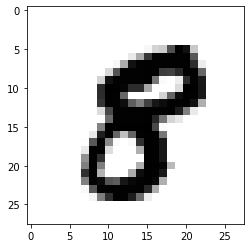

8.0




In [8]:
from keras.datasets import mnist
import random
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import tabulate

# No necesitamos tantos datos.
(X_train, y_train), (X_test, y_test) = mnist.load_data()
#random.seed(123) # Vamos a controlar la aleatoriedad en adelante. 
X, y = zip(*random.sample(list(zip(X_train, y_train)), 2000))

# Sí necesitamos que la forma de X sea la de un vector, en lugar de una matriz. 
X, y = np.array(X, dtype='float64'), np.array(y, dtype='float64')
#X = np.reshape(X, (X.shape[0], -1)) # YA NO QUEREMOS TRANSFORMAR EN VECTO X
# AHORA NOS SERVIRÁ QUE SEA UNA MATRIZ, LA PROCESAREMOS CON CAPA DE CONVOLUCIÓN.

# APLICAREMOS UN RESHAPE Y NORMALIZACIÓN MÁS AD-HOC PARA ESTE CASO
X = X.reshape(X.shape[0], 28, 28, 1)


print(tabulate.tabulate(X[0]))
fig = plt.figure
plt.imshow(X[0], cmap='gray_r')
plt.show()
print(y[0])
print()
print()

In [9]:

# Dividimos la muestra en dos, una para entrenar y otra para testing, como tenemos 
# muestra de sobra nos damos el lujo de testear con la misma cantidad que entrenamos.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=123)

# Necesitamos que y_train sea un valor categórico, en lugar de un dígito entero.
y_train_value = y_train # Guardaremos y_train como valor para un observación más abajo.
from keras.utils import to_categorical
y_train = to_categorical(y_train)

# ESTANDARIZACION MANUAL: Habíamos usado MinMax, pero
# no nos servirá al usar red de convolución, que necesita recibir una grilla.
# Además, preferimos usar estandarización (prob normal) en lugar de simple escalado
# Calculamos la media y la desviación estándar
mean = np.mean(X_train)
std = np.std(X_train)
# Estandarizamos calculando el estadístico Z, que reemplaza a los datos originales.
X_train = (X_train - mean) / std
# La misma transformación aplica a los datos de testeo.
# Notese que la media y desviación son los que calculamos para la
# muestra de entrenamiento. O sea, los datos de prueba son observaciones
# limpias, que no siquiera influyeron en la normalización de los datos. 
X_test = (X_test - mean) / std



---------  ---------  ---------  ---------  ---------  ---------  ----------  ---------  ---------  ---------  ---------  ----------  ---------  ---------  ---------  ----------  ---------  ----------  ----------  ---------  ---------  ----------  ---------  ---------  ---------  ---------  ---------  ---------
-0.422264  -0.422264  -0.422264  -0.422264  -0.422264  -0.422264  -0.422264   -0.422264  -0.422264  -0.422264  -0.422264  -0.422264   -0.422264  -0.422264  -0.422264  -0.422264   -0.422264  -0.422264   -0.422264   -0.422264  -0.422264  -0.422264   -0.422264  -0.422264  -0.422264  -0.422264  -0.422264  -0.422264
-0.422264  -0.422264  -0.422264  -0.422264  -0.422264  -0.422264  -0.422264   -0.422264  -0.422264  -0.422264  -0.422264  -0.422264   -0.422264  -0.422264  -0.422264  -0.422264   -0.422264  -0.422264   -0.422264   -0.422264  -0.422264  -0.422264   -0.422264  -0.422264  -0.422264  -0.422264  -0.422264  -0.422264
-0.422264  -0.422264  -0.422264  -0.422264  -0.422264  -0.422

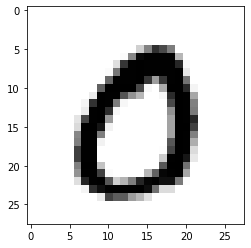

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]




In [10]:
print(tabulate.tabulate(X_train[0]))
fig = plt.figure
plt.imshow(X_train[0], cmap='gray_r')
plt.show()
print(y_train[0])
print()
print()

Nuestra arquitectura típica sería aplicar capas de: Convolución, Activación, Pooling (si tuvieramos), repetir lo anterior con distintas cantidades de filtros (generalmente descendente), y cerrar la parte convolución con una capa de aplanado (flatten). Luego sigue una red densa con las capas que necesitemos. 

Seguimos expuestos a todos los problema: desvanecimiento del gradiente, sobre-ajuste... Tenemos la mismas acciones de mitigación que ya conocíamos, por ejemplo regularización $L2$ (Ridge), uso de activaciones ReLU...

In [11]:
import time

#Esto se va a demorar, registremos cuanto. 
inicio = time.time()

# Crear instancia de Network
model = Network()

# Cantidad y Tamaño del kernel
kernels = 8
kernel_size = 3

# Tamaño / forma de la entrada
input_shape = X_train[0].shape

# Parámetro regularizados
lambda_reg = 0.001

# Agregamos capas al modelo
model.add(ConvLayer(input_shape, (kernel_size, kernel_size), kernels, lambda_reg=lambda_reg)) # Capa de Convolución con un kernels
model.add(ActivationLayer(relu, relu_prime))
model.add(FlattenLayer())  # Capa de Flatten para aplanar la salida
model.add(FCLayer(input_shape[0]*input_shape[1]*kernels, 128, lambda_reg=lambda_reg))
model.add(ActivationLayer(tanh, tanh_prime))
model.add(FCLayer(128, 10, lambda_reg=lambda_reg)) 
model.add(ActivationLayer(sigmoid, sigmoid_prime))

# Asignamos función de pérdida
model.use(mse, mse_prime)

# Entrenamos el modelo con datos de entrenamiento
model.fit(X_train, y_train, epochs=10, learning_rate=0.01) #HEMOS REDUCIDO LA TASA DE APRENDIZAJE

# Usamos el modelo para predecir sobre los datos de prueba (validación)
y_hat = model.predict(X_test)

# Transformamos la salida en un vector one-hot encoded, es decir 0s y un 1. 
for i in range(len(y_hat)):
    y_hat[i] = np.argmax(y_hat[i][0])

# Reportamos los resultados del modelo
matriz_conf = confusion_matrix(y_test, y_hat)

print('MATRIZ DE CONFUSIÓN para modelo ANN')
print(matriz_conf,'\n')
print('La exactitud de testeo del modelo ANN es: {:.3f}'.format(accuracy_score(y_test,y_hat)))
fin = time.time() 
duración = fin - inicio
print('Se demoró {:.2f} minutos.'.format(duración/60))

epoch 1/10   error=0.097138
epoch 2/10   error=0.079502
epoch 3/10   error=0.072576
epoch 4/10   error=0.067519
epoch 5/10   error=0.064523
epoch 6/10   error=0.058596
epoch 7/10   error=0.054879
epoch 8/10   error=0.048805
epoch 9/10   error=0.044500
epoch 10/10   error=0.040971
MATRIZ DE CONFUSIÓN para modelo ANN
[[ 74   0   1   3   0   2   5   1   7   3]
 [  0 108   1   0   0   1   5   1  10   2]
 [  1   0  75   1   2   0   8   3  14   3]
 [  3   0   5  62   0   7   4   4  16  10]
 [  0   1   0   0  52   1  13   7   1  12]
 [  1   3   0  17   6  37   5  11   3   0]
 [  0   0   0   0   0   1  85   0   3   0]
 [  0   0   0   0   3   0   0  91   3  10]
 [  0   0   1   9   2   3   8   1  67   3]
 [  0   0   1   2   6   3   0  18   4  64]] 

La exactitud de testeo del modelo ANN es: 0.715
Se demoró 17.30 minutos.


El factor crítico que comienza a limitarnos es el tiempo, sobre todo por la implementación aún incompleta que tenemos. Al no tener mini batch los pesos se ajustan en cada observación, cada epoch. Al no tener ningún tipo de pooling, no tenemos como reducir el tamaño del modelo con ajuste entre capas. Implementar estas tareas ayudaría a entrenar en tiempos un poco más razonables. Además, menor dimensionalidad gracias al pooling también ayudará a evitar sobreajuste. 

In [12]:
import time

#Esto se va a demorar, registremos cuanto. 
inicio = time.time()

# CONTINUAREMOS ENTRENANDO EL MISMO MODELO QUE YA AVANZAMOS EN LA CELDA ANTERIOR
# Entrenamos el modelo con datos de entrenamiento
model.fit(X_train, y_train, epochs=90, learning_rate=0.01) # VAMOS A COMPLETAR 100 EPOCHS

# Usamos el modelo para predecir sobre los datos de prueba (validación)
y_hat = model.predict(X_test)

# Transformamos la salida en un vector one-hot encoded, es decir 0s y un 1. 
for i in range(len(y_hat)):
    y_hat[i] = np.argmax(y_hat[i][0])

# Reportamos los resultados del modelo
matriz_conf = confusion_matrix(y_test, y_hat)

print('MATRIZ DE CONFUSIÓN para modelo ANN')
print(matriz_conf,'\n')
print('La exactitud de testeo del modelo ANN es: {:.3f}'.format(accuracy_score(y_test,y_hat)))
fin = time.time() 
duración = fin - inicio
print('Se demoró {:.2f} minutos.'.format(duración/60))

epoch 1/90   error=0.037811
epoch 2/90   error=0.036657
epoch 3/90   error=0.036635
epoch 4/90   error=0.033345
epoch 5/90   error=0.030705
epoch 6/90   error=0.030780
epoch 7/90   error=0.029014
epoch 8/90   error=0.028610
epoch 9/90   error=0.026342
epoch 10/90   error=0.024468
epoch 11/90   error=0.021909
epoch 12/90   error=0.021076
epoch 13/90   error=0.021775
epoch 14/90   error=0.020392
epoch 15/90   error=0.021296
epoch 16/90   error=0.019095
epoch 17/90   error=0.017861
epoch 18/90   error=0.018216
epoch 19/90   error=0.016560
epoch 20/90   error=0.015780
epoch 21/90   error=0.014692
epoch 22/90   error=0.013501
epoch 23/90   error=0.012014
epoch 24/90   error=0.011609
epoch 25/90   error=0.011273
epoch 26/90   error=0.011024
epoch 27/90   error=0.010335
epoch 28/90   error=0.010383
epoch 29/90   error=0.009448
epoch 30/90   error=0.008440
epoch 31/90   error=0.007859
epoch 32/90   error=0.007800
epoch 33/90   error=0.007318
epoch 34/90   error=0.006968
epoch 35/90   error=0.0

<b>Pongámosle Color</b>

Puede que tenga usted la duda de qué tan general es esta implementación de red neuronal convolucional, para tareas con distintos tipos de imágenes. Sólo para ilustrar, cambiaremos a un problema a todo color, es decir con imagenes presentadas en tres canales de color. 

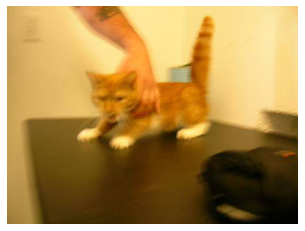

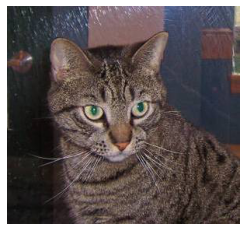

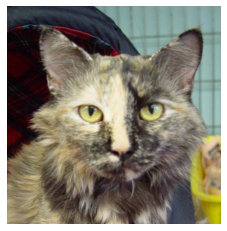

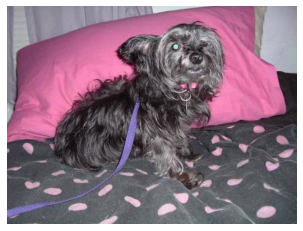

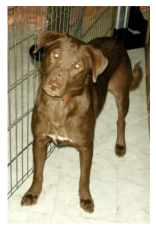

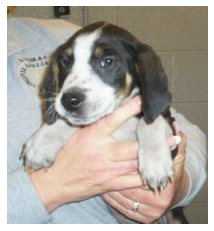

In [13]:
import tensorflow as tf

# Descargar el dataset
url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
dataset = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=url, extract=True)

# Directorio de las imágenes
import os
base_dir = os.path.join(os.path.dirname(dataset), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Obteniendo la lista de imágenes de gatos y perros
cat_images = os.listdir(train_cats_dir)
dog_images = os.listdir(train_dogs_dir)

# Función para visualizar las imágenes
def show_image(img_path):
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Mostrar algunos gatos y un perros
show_image(os.path.join(train_cats_dir, cat_images[0]))
show_image(os.path.join(train_cats_dir, cat_images[1]))
show_image(os.path.join(train_cats_dir, cat_images[2]))
show_image(os.path.join(train_dogs_dir, dog_images[0]))
show_image(os.path.join(train_dogs_dir, dog_images[1]))
show_image(os.path.join(train_dogs_dir, dog_images[2]))

In [14]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Definir rutas de los directorios de datos
base_dir = os.path.join(os.path.dirname(dataset), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'validation')

# Función para cargar imágenes y etiquetas de un directorio
def load_images_and_labels(directory, label_map, target_size=(150, 150)):
    images = []
    labels = []
    for label, label_id in label_map.items():
        class_dir = os.path.join(directory, label)
        for img_path in os.listdir(class_dir):
            img = load_img(os.path.join(class_dir, img_path), target_size=target_size)
            images.append(img_to_array(img))
            labels.append(label_id)
    return np.array(images), np.array(labels)

# Cargar imágenes y etiquetas
label_map = {'cats': 0, 'dogs': 1}
X_train, y_train = load_images_and_labels(train_dir, label_map)
X_test, y_test = load_images_and_labels(test_dir, label_map)

# Estandarización manual
mean = np.mean(X_train)
std = np.std(X_train)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

# Convertir etiquetas a categóricas
y_train = to_categorical(y_train)



La sugiente celda se demorará mucho en ejecutarse, sobre todo mientras no le incorporemos pooling y mini batch. Pero para que quede claro que la CNN que hemos implementado hasta acá sí soporta imagenes a color, vamos a entrenar dos epoch. Obviamente no se espera resultados muy buenos, pero es mejor que nada. Cuando tengamos los componentes que nos faltan, podremos acelerar un poco el aprendizaje de la red.  

In [15]:
import time

#Esto se va a demorar, registremos cuanto. 
inicio = time.time()

# Crear instancia de Network
model = Network()

# Cantidad y Tamaño del kernel
kernels = 1
kernel_size = 3

# Tamaño / forma de la entrada
input_shape = X_train[0].shape

# Parámetro regularizados
lambda_reg = 0.001

# Agregamos capas al modelo
model.add(ConvLayer(input_shape, (kernel_size, kernel_size), kernels, lambda_reg=lambda_reg)) # Capa de Convolución
model.add(ActivationLayer(relu, relu_prime))
model.add(FlattenLayer())  # Capa de Flatten para aplanar la salida
model.add(FCLayer(input_shape[0]*input_shape[1]*kernels, 128, lambda_reg=lambda_reg))
model.add(ActivationLayer(tanh, tanh_prime))
model.add(FCLayer(128, 2, lambda_reg=lambda_reg)) 
model.add(ActivationLayer(sigmoid, sigmoid_prime))

# Asignamos función de pérdida
model.use(mse, mse_prime)

# Entrenamos el modelo con datos de entrenamiento
model.fit(X_train, y_train, epochs=2, learning_rate=0.01)

# Usamos el modelo para predecir sobre los datos de prueba (validación)
y_hat = model.predict(X_test)

# Transformamos la salida en un vector one-hot encoded, es decir 0s y un 1. 
for i in range(len(y_hat)):
    y_hat[i] = np.argmax(y_hat[i][0])

# Reportamos los resultados del modelo
matriz_conf = confusion_matrix(y_test, y_hat)

print('MATRIZ DE CONFUSIÓN para modelo ANN')
print(matriz_conf,'\n')
print('La exactitud de testeo del modelo ANN es: {:.3f}'.format(accuracy_score(y_test,y_hat)))
fin = time.time() 
duración = fin - inicio
print('Se demoró {:.2f} minutos.'.format(duración/60))

epoch 1/2   error=0.148798
epoch 2/2   error=0.204432
MATRIZ DE CONFUSIÓN para modelo ANN
[[  0 500]
 [  1 499]] 

La exactitud de testeo del modelo ANN es: 0.499
Se demoró 65.10 minutos.


Pero no será suficiente, implementaciones más profesionales se construyen para distribuir tareas en paralelo, soportadas por GPU, para lo cual se suele usar estructuras de datos denominadas <i>Tensores</i>. Eso se escapa del alcance que le daremos a nuestro proyecto de red sin librerías, que sólo tiene fines pedagógicos. En próximas clases usaremos implementaciones ya disponibles, justamente para observar como mejora el desempeño de las redes gracias al uso de GPU mediante tensores. Pero el proceso de aprendizaje en esas implementaciones no es distino, en escencia, a la matemática que hemos desarrollado en nuestra humilde implementación. 